<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/PlayingWithPandasStructures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing datastructures, exploring what's possible

# Setup env


In [0]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# test, peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# test, modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27 12:01 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27 12:01 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27 12:01 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27 12:01 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27 12:01 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27 12:01 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27 12:01 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27 12:01 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27 12:01 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27 12:01 9_soul-groove9_105_beat_4-4.mid
total 34
-rw------- 1 root root 21727 Jun  4 19:53 data_prep.py
drwx------ 2 root root  4096 May 10 13:31 __pycache__
-rw------- 1 root root  8416 Jun  2 21:24 visualizations.py


## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [0]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [5]:
# install required libs
!pip install mido

In [6]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep

LOADING custom module, when: 2020-06-12 00:41:39.974964, module name: data_prep


In [0]:
# imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np


# object that provides colours for charts
from itertools import cycle



In [8]:
# testing auto reload of modules 
data_prep.test_function_call('bling')

Test function called worked! when: 2020-06-12 00:41:40.019446,  param:bling


## Pandas display options

In [0]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Pandas series and dataframe Indexing techniques

Working through some of these...
- https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
- https://github.com/ZaxR/pandas_multiindex_tutorial/blob/master/Pandas%20MultiIndex%20Tutorial.ipynb
- https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html

In [10]:
dates = pd.date_range('1/1/2000', periods=24)
dates

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14', '2000-01-15', '2000-01-16',
               '2000-01-17', '2000-01-18', '2000-01-19', '2000-01-20',
               '2000-01-21', '2000-01-22', '2000-01-23', '2000-01-24'],
              dtype='datetime64[ns]', freq='D')

In [11]:
df = pd.DataFrame(np.random.randn(24,4),
                  index=dates, columns=['A','B', 'C','D'])
df

,A,B,C,D
2000-01-01,-0.500443,0.336819,0.880903,-0.182715
2000-01-02,0.690160,-0.414964,-0.560315,1.009060
2000-01-03,1.065931,-0.494859,0.389298,0.637908
2000-01-04,-1.012278,1.263852,0.084206,0.318290
2000-01-05,-1.282569,-0.002446,-0.003098,1.362501
2000-01-06,0.060328,-0.632129,0.078547,0.768542
2000-01-07,0.918502,1.003849,0.465140,1.050423
2000-01-08,-1.533393,0.705457,-0.702264,-0.337670
2000-01-09,-1.123094,-0.050847,-0.923270,1.230867
2000-01-10,0.458405,-0.498561,1.257535,-0.233272


In [12]:
s = df['A']
my_i = 13
print('index {}: {}'.format(my_i, s[dates[my_i]]))
s[:my_i]

index 13: -0.18963617704759542


2000-01-01   -0.500443
2000-01-02    0.690160
2000-01-03    1.065931
2000-01-04   -1.012278
2000-01-05   -1.282569
2000-01-06    0.060328
2000-01-07    0.918502
2000-01-08   -1.533393
2000-01-09   -1.123094
2000-01-10    0.458405
2000-01-11   -0.168792
2000-01-12   -1.756170
2000-01-13   -1.005291
Freq: D, Name: A, dtype: float64

In [13]:
s[::3]  # select every 3rd element

2000-01-01   -0.500443
2000-01-04   -1.012278
2000-01-07    0.918502
2000-01-10    0.458405
2000-01-13   -1.005291
2000-01-16   -0.438768
2000-01-19    0.146692
2000-01-22   -0.010219
Freq: 3D, Name: A, dtype: float64

In [14]:
# select rows 3 thru 8, not including 8, then
# columns 2 thru 3, not including 3
df.iloc[3:8, 2:3] 

# select rows 3 and 4, column 2
df.iloc[[3,4], [2]]

,C
2000-01-04,0.084206
2000-01-05,-0.003098
2000-01-06,0.078547
2000-01-07,0.465140
2000-01-08,-0.702264


,C
2000-01-04,0.084206
2000-01-05,-0.003098


In [15]:
df.sample(3)  # select random sample

,A,B,C,D
2000-01-14,-0.189636,-1.570318,-0.845131,-0.509084
2000-01-02,0.690160,-0.414964,-0.560315,1.009060
2000-01-20,-2.626133,-1.633106,-0.001528,1.780506


## Boolean indexing series

This looks pretty powerful...
- https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing

In [16]:
s = pd.Series(range(-3,4))
s
s[s > 0]
s[(s < -2)|(s>1.8)]

0   -3
1   -2
2   -1
3    0
4    1
5    2
6    3
dtype: int64

4    1
5    2
6    3
dtype: int64

0   -3
5    2
6    3
dtype: int64

## MultiIndex and 'isin' stuff

using Series...

In [17]:
s_mi = pd.Series(np.arange(6),
                           index=pd.MultiIndex.from_product([[0,1], ['a','b','c']]))
s_mi

0  a    0
   b    1
   c    2
1  a    3
   b    4
   c    5
dtype: int64

In [18]:
# this matches on 2 levels of index
s_mi.iloc[s_mi.index.isin([(1,'a'), (0,'c')])]

0  c    2
1  a    3
dtype: int64

In [19]:
# specify index level to test against

# pull out everything with index 'c' at 
# level 1 (i.e. 0, 1, therefore 1 is 
# the second index level)
s_mi.iloc[s_mi.index.isin(['c'], level=1)]

0  c    2
1  c    5
dtype: int64

using DataFrames...

In [20]:
df = pd.DataFrame({'vals': [1,2,3,4], 'ids': ['a','b','f','n'],
                   'ids2': ['a','n','c','n']})
df

# search entire df for list of values
values = ['a','b',1,3]
df.isin(values)

,vals,ids,ids2
0,1,a,a
1,2,b,n
2,3,f,c
3,4,n,n


,vals,ids,ids2
0,True,True,True
1,False,True,False
2,True,False,False
3,False,False,False


In [21]:
# search only specific columns
values = {'ids': ['a','n'], 'vals': [1,4]}
df.isin(values)

,vals,ids,ids2
0,True,True,False
1,False,False,False
2,False,False,False
3,True,True,False


Renaming multiindexes, levels, etc. and whatnot ...

In [22]:
index = pd.MultiIndex.from_product([range(3),['wun','too']], names=['furst', 'secund'])
index

MultiIndex([(0, 'wun'),
            (0, 'too'),
            (1, 'wun'),
            (1, 'too'),
            (2, 'wun'),
            (2, 'too')],
           names=['furst', 'secund'])

In [23]:
print('look at second level index, at [1]: {}'.format(index.levels[1]))
index.set_levels(['x','y','t'], level=1, inplace=True)
index


look at second level index, at [1]: Index(['too', 'wun'], dtype='object', name='secund')


MultiIndex([(0, 'y'),
            (0, 'x'),
            (1, 'y'),
            (1, 'x'),
            (2, 'y'),
            (2, 'x')],
           names=['furst', 'secund'])

## Setting multi/index from columns, resetting

More info here ...
- https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#set-reset-index


# Setup test file

## Load file

In [0]:
mapping = data_prep.simplified_mapping

In [25]:
file_name = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
#file_name = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'
midi_file = data_prep.MIDI_File_Wrapper(file_name, mapping)
f = midi_file
f_df = f.df_midi_data

FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 6, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 42.0: 'Closed Hi Hat (42)', 43.0: 'High Floor Tom (43)', 49.0: 'Crash Cymbal 1 (49)', 51.0: 'Ride Cymbal 1 (51)'}


... the above verifies I'm able to create custom objects from custom code, great!


## Setup MIDI event timing bins...

In [26]:
# MTT object for parsing file and
# calculating crticial time metrics
mtt = data_prep.MidiTimingTools(file_name, f.ticks(), f.tempo_us(), f.ts_num(), f.ts_denom(), f.last_hit())

# values needed these for making MultiIndex later
quantize_level = mtt.bins_per_bar()
bars_in_file = mtt.bars_in_file()
tp_beat = mtt.ts_ticks_per_beat()
tp_bin = mtt.bin_size()

print('bar info - bars in file: {}, bar quantize level: {}'.format(bars_in_file, quantize_level))
print('tick info - ticks per time sig beat: {}, ticks per quantize bin: {}'.format(tp_beat, tp_bin))

# capture timing data from MidiTimingTools in df...
beats_col, offsets_col = mtt.get_offsets(f_df[f.cum_ticks_col])
f_df['beat_offset'] = offsets_col
f_df['beat_center'] = beats_col
f_df['file_beat_number'] = pd.Categorical(f_df.beat_center).codes



bar info - bars in file: 16, bar quantize level: 16.0
tick info - ticks per time sig beat: 480.0, ticks per quantize bin: 120


In [27]:
f_df.head(100)

,track_msg_num,msg_type,delta_ticks,total_ticks,total_seconds,note,velocity,raw_data,beat_offset,beat_center,file_beat_number
0,0:0,track_name,0,0,0.000000,NaN,NaN,"{'type': 'track_name', 'name': 'MIDI', 'time': 0}",0,0,0
1,0:1,instrument_name,0,0,0.000000,NaN,NaN,"{'type': 'instrument_name', 'name': 'Brooklyn', 'time': 0}",0,0,0
2,0:2,time_signature,0,0,0.000000,NaN,NaN,"{'type': 'time_signature', 'numerator': 4, 'denominator': 4, 'clocks_per_click': 24, 'notated_32nd_notes_per_beat': 8, 'time': 0}",0,0,0
3,0:3,key_signature,0,0,0.000000,NaN,NaN,"{'type': 'key_signature', 'key': 'C', 'time': 0}",0,0,0
4,0:4,smpte_offset,0,0,0.000000,NaN,NaN,"{'type': 'smpte_offset', 'frame_rate': 24, 'hours': 33, 'minutes': 0, 'seconds': 0, 'frames': 0, 'sub_frames': 0, 'time': 0}",0,0,0
5,0:5,set_tempo,0,0,0.000000,NaN,NaN,"{'type': 'set_tempo', 'tempo': 434783, 'time': 0}",0,0,0
6,0:6,note_on,3,3,0.002717,49.0,60.0,"{'type': 'note_on', 'time': 3, 'note': 55, 'velocity': 60, 'channel': 9}",3,0,0
7,0:7,note_on,4,7,0.006341,51.0,55.0,"{'type': 'note_on', 'time': 4, 'note': 51, 'velocity': 55, 'channel': 9}",7,0,0
8,0:8,note_on,3,10,0.009058,36.0,64.0,"{'type': 'note_on', 'time': 3, 'note': 36, 'velocity': 64, 'channel': 9}",10,0,0
9,0:9,control_change,3,13,0.011775,NaN,NaN,"{'type': 'control_change', 'time': 3, 'control': 4, 'value': 90, 'channel': 9}",13,0,0


In [28]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   track_msg_num     1300 non-null   object  
 1   msg_type          1300 non-null   string  
 2   delta_ticks       1300 non-null   int64   
 3   total_ticks       1300 non-null   int64   
 4   total_seconds     1300 non-null   float64 
 5   note              820 non-null    float64 
 6   velocity          820 non-null    float64 
 7   raw_data          1300 non-null   string  
 8   beat_offset       1300 non-null   int64   
 9   beat_center       1300 non-null   category
 10  file_beat_number  1300 non-null   int16   
dtypes: category(1), float64(3), int16(1), int64(3), object(1), string(2)
memory usage: 96.7+ KB


## Setup columns indicating bars & beats

These new columns will be needed for the new MultiIndex that needs to be created

In [0]:
# make a copy, just to practice on 
tmp_df = f_df.copy(deep=True)

In [0]:
# add column for bear index
tmp_df['bar_number'] = (tmp_df.file_beat_number // quantize_level) + 1

In [0]:
# add column for beat within the bar index
tmp_df['bar_beat_number'] = (tmp_df.file_beat_number % 16) + 1

In [0]:
# sort out types
tmp_df['bar_number'] = tmp_df['bar_number'].astype('int')
tmp_df['bar_beat_number'] = tmp_df['bar_beat_number'].astype('int')

#tmp_df['bar_number'] = tmp_df['bar_number'].astype('str') 
#tmp_df['bar_beat_number'] = tmp_df['bar_beat_number'].astype('str') 

In [0]:
# filter to only note_on events
tmp_df = tmp_df[tmp_df['msg_type'] == 'note_on'].copy() 


In [34]:
# test for presence of column
col_test = ['msg_type', 'plop', 'note']
for next in col_test:
  print('{} : {}'.format(next, next in tmp_df))



msg_type : True
plop : False
note : True


In [35]:
tmp_df.info()
tmp_df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 6 to 1296
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   track_msg_num     412 non-null    object  
 1   msg_type          412 non-null    string  
 2   delta_ticks       412 non-null    int64   
 3   total_ticks       412 non-null    int64   
 4   total_seconds     412 non-null    float64 
 5   note              412 non-null    float64 
 6   velocity          412 non-null    float64 
 7   raw_data          412 non-null    string  
 8   beat_offset       412 non-null    int64   
 9   beat_center       412 non-null    category
 10  file_beat_number  412 non-null    int16   
 11  bar_number        412 non-null    int64   
 12  bar_beat_number   412 non-null    int64   
dtypes: category(1), float64(3), int16(1), int64(5), object(1), string(2)
memory usage: 40.4+ KB


,track_msg_num,msg_type,delta_ticks,total_ticks,total_seconds,note,velocity,raw_data,beat_offset,beat_center,file_beat_number,bar_number,bar_beat_number
6,0:6,note_on,3,3,0.002717,49.0,60.0,"{'type': 'note_on', 'time': 3, 'note': 55, 'velocity': 60, 'channel': 9}",3,0,0,1,1
7,0:7,note_on,4,7,0.006341,51.0,55.0,"{'type': 'note_on', 'time': 4, 'note': 51, 'velocity': 55, 'channel': 9}",7,0,0,1,1
8,0:8,note_on,3,10,0.009058,36.0,64.0,"{'type': 'note_on', 'time': 3, 'note': 36, 'velocity': 64, 'channel': 9}",10,0,0,1,1
14,0:14,note_on,22,211,0.191123,36.0,57.0,"{'type': 'note_on', 'time': 22, 'note': 36, 'velocity': 57, 'channel': 9}",-29,240,2,1,3
16,0:16,note_on,17,238,0.215580,51.0,31.0,"{'type': 'note_on', 'time': 17, 'note': 51, 'velocity': 31, 'channel': 9}",-2,240,2,1,3
22,0:22,note_on,1,446,0.403986,42.0,77.0,"{'type': 'note_on', 'time': 1, 'note': 44, 'velocity': 77, 'channel': 9}",-34,480,4,1,5
23,0:23,note_on,21,467,0.423008,51.0,54.0,"{'type': 'note_on', 'time': 21, 'note': 51, 'velocity': 54, 'channel': 9}",-13,480,4,1,5
24,0:24,note_on,8,475,0.430254,38.0,93.0,"{'type': 'note_on', 'time': 8, 'note': 38, 'velocity': 93, 'channel': 9}",-5,480,4,1,5
32,0:32,note_on,0,666,0.603261,42.0,52.0,"{'type': 'note_on', 'time': 0, 'note': 44, 'velocity': 52, 'channel': 9}",-54,720,6,1,7
34,0:34,note_on,2,704,0.637682,51.0,42.0,"{'type': 'note_on', 'time': 2, 'note': 51, 'velocity': 42, 'channel': 9}",-16,720,6,1,7


## Drop other columns we don't need

In [0]:
tmp_df.drop(columns=['msg_type', 'delta_ticks', 'total_seconds',  'raw_data', 'file_beat_number' ], inplace=True)

In [37]:
tmp_df.head()


,track_msg_num,total_ticks,note,velocity,beat_offset,beat_center,bar_number,bar_beat_number
6,0:6,3,49.0,60.0,3,0,1,1
7,0:7,7,51.0,55.0,7,0,1,1
8,0:8,10,36.0,64.0,10,0,1,1
14,0:14,211,36.0,57.0,-29,240,1,3
16,0:16,238,51.0,31.0,-2,240,1,3


# Set bar & beat MultiIndex

In [0]:
tmp_df_no_index = tmp_df.copy()  # save a copy for later
tmp_df.set_index(['bar_number', 'bar_beat_number'], inplace=True)

In [39]:
tmp_df.index.names

FrozenList(['bar_number', 'bar_beat_number'])

In [40]:
tmp_df.head()
tmp_df.info()

track_msg_num  total_ticks  note  velocity  \
bar_number bar_beat_number                                              
1          1                         0:6            3  49.0      60.0   
           1                         0:7            7  51.0      55.0   
           1                         0:8           10  36.0      64.0   
           3                        0:14          211  36.0      57.0   
           3                        0:16          238  51.0      31.0   

                            beat_offset beat_center  
bar_number bar_beat_number                           
1          1                          3           0  
           1                          7           0  
           1                         10           0  
           3                        -29         240  
           3                         -2         240

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 412 entries, (1, 1) to (16, 16)
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   track_msg_num  412 non-null    object  
 1   total_ticks    412 non-null    int64   
 2   note           412 non-null    float64 
 3   velocity       412 non-null    float64 
 4   beat_offset    412 non-null    int64   
 5   beat_center    412 non-null    category
dtypes: category(1), float64(2), int64(2), object(1)
memory usage: 18.2+ KB


## Test data selection methods

In [41]:
# select everything in bar #1
tmp_df.loc[1]

,track_msg_num,total_ticks,note,velocity,beat_offset,beat_center
bar_beat_number,,,,,,
1,0:6,3,49.0,60.0,3,0
1,0:7,7,51.0,55.0,7,0
1,0:8,10,36.0,64.0,10,0
3,0:14,211,36.0,57.0,-29,240
3,0:16,238,51.0,31.0,-2,240
5,0:22,446,42.0,77.0,-34,480
5,0:23,467,51.0,54.0,-13,480
5,0:24,475,38.0,93.0,-5,480
7,0:32,666,42.0,52.0,-54,720


In [42]:
# select hits in 5th beat, first bar
# .loc in this case only works for leftmost index such
# that if there is no match with anything in left most
# index it will throw an error. 
tmp_df.loc[1].loc[5]

,track_msg_num,total_ticks,note,velocity,beat_offset,beat_center
bar_beat_number,,,,,,
5,0:22,446,42.0,77.0,-34,480
5,0:23,467,51.0,54.0,-13,480
5,0:24,475,38.0,93.0,-5,480


In [43]:
# more selection mechanisms...
#tmp_df.xs(1)
tmp_df.loc[1].loc[1]

# NOTE: the below will FAIL if integer given
# in 2nd 'loc' doesn't exist in result set!!!
tmp_df.loc[1].loc[3, ( 'note', 'beat_offset')] 

,track_msg_num,total_ticks,note,velocity,beat_offset,beat_center
bar_beat_number,,,,,,
1,0:6,3,49.0,60.0,3,0
1,0:7,7,51.0,55.0,7,0
1,0:8,10,36.0,64.0,10,0


,note,beat_offset
bar_beat_number,,
3,36.0,-29
3,51.0,-2


In [44]:
# selects bars 3-4
tmp_df.loc[3:4]

track_msg_num  total_ticks  note  velocity  \
bar_number bar_beat_number                                              
3          1                       0:161         3796  38.0      33.0   
           1                       0:165         3823  42.0      72.0   
           1                       0:166         3836  36.0      57.0   
           1                       0:167         3837  51.0      45.0   
           1                       0:168         3846  38.0      23.0   
           3                       0:177         4043  42.0      22.0   
           3                       0:178         4072  36.0      62.0   
           3                       0:180         4080  51.0      45.0   
           5                       0:187         4300  42.0      80.0   
           5                       0:188         4317  38.0      88.0   
           5                       0:189         4321  51.0      50.0   
           7                       0:196         4528  42.0      57.0   
           7                       0:198         4564  51.0      36.0   
           8                       0:200         4668  38.0      86.0   
           9                       0:206         4783  42.0      75.0   
           9                       0:207         4806  51.0      49.0   
           10                      0:210         4905  38.0      27.0   
           11                      0:214         5007  42.0      57.0   
           11                      0:216         5038  36.0      66.0   
           11                      0:217         5040  51.0      47.0   
           13                      0:225         5248  42.0      77.0   
           13                      0:226         5269  51.0      39.0   
           15                      0:232         5479  42.0      52.0   
           15                      0:233         5507  51.0      51.0   
           15                      0:235         5518  38.0      94.0   
4          1                       0:242         5730  42.0      77.0   
           1                       0:243         5748  51.0      43.0   
           2                       0:246         5845  38.0      38.0   
           3                       0:252         5964  42.0      60.0   
           3                       0:253         5971  51.0      41.0   
           3                       0:254         5975  36.0      45.0   
           4                       0:259         6100  36.0      48.0   
           5                       0:262         6210  51.0      53.0   
           5                       0:264         6216  38.0      99.0   
           5                       0:266         6222  42.0      80.0   
           7                       0:274         6448  42.0      55.0   
           7                       0:275         6451  51.0      45.0   
           8                       0:277         6556  38.0      88.0   
           9                       0:283         6687  51.0      58.0   
           9                       0:285         6700  42.0      80.0   
           10                      0:289         6813  38.0      37.0   
           10                      0:290         6867  38.0      20.0   
           11                      0:294         6916  42.0      40.0   
           11                      0:295         6923  49.0      61.0   
           11                      0:296         6924  36.0      71.0   
           13                      0:305         7160  42.0      80.0   
           13                      0:306         7163  51.0      49.0   
           15                      0:313         7383  42.0      62.0   
           15                      0:314         7400  38.0     105.0   
           15                      0:315         7401  51.0      56.0   

                            beat_offset beat_center  
bar_number bar_beat_number                           
3          1                        -44        3840  
           1                        -17        3840  
           1  

In [45]:
tmp_df.index.names

FrozenList(['bar_number', 'bar_beat_number'])

In [46]:
# extract all notes in the first 1/16th note of a bar
# NOTE: 'level' refers to index, level 0 = bar_number, level 1 = bar_beat_number
tmp_df[tmp_df.index.isin([1], level=1)]

track_msg_num  total_ticks  note  velocity  \
bar_number bar_beat_number                                              
1          1                         0:6            3  49.0      60.0   
           1                         0:7            7  51.0      55.0   
           1                         0:8           10  36.0      64.0   
2          1                        0:79         1879  42.0      72.0   
           1                        0:81         1913  51.0      42.0   
           1                        0:83         1915  36.0      55.0   
3          1                       0:161         3796  38.0      33.0   
           1                       0:165         3823  42.0      72.0   
           1                       0:166         3836  36.0      57.0   
           1                       0:167         3837  51.0      45.0   
           1                       0:168         3846  38.0      23.0   
4          1                       0:242         5730  42.0      77.0   
           1                       0:243         5748  51.0      43.0   
5          1                       0:323         7620  42.0      77.0   
           1                       0:324         7651  51.0      51.0   
           1                       0:326         7657  36.0      50.0   
           1                       0:328         7735  38.0      34.0   
6          1                       0:409         9570  42.0      80.0   
           1                       0:410         9576  38.0      23.0   
           1                       0:413         9598  51.0      60.0   
           1                       0:414         9599  36.0      55.0   
7          1                       0:493        11468  38.0      33.0   
           1                       0:497        11510  42.0      77.0   
           1                       0:498        11530  36.0      62.0   
           1                       0:499        11530  51.0      60.0   
8          1                       0:574        13429  42.0      77.0   
           1                       0:575        13446  51.0      48.0   
9          1                       0:655        15318  42.0      75.0   
           1                       0:656        15335  36.0      60.0   
           1                       0:657        15349  51.0      54.0   
           1                       0:659        15407  38.0      33.0   
10         1                       0:735        17241  38.0      25.0   
           1                       0:738        17244  42.0      82.0   
           1                       0:739        17256  36.0      64.0   
           1                       0:742        17279  51.0      49.0   
11         1                       0:822        19157  38.0      25.0   
           1                       0:826        19181  42.0      80.0   
           1                       0:827        19185  36.0      67.0   
           1                       0:828        19196  51.0      57.0   
12         1                       0:902        21108  42.0      80.0   
           1                       0:903        21129  51.0      51.0   
13         1                       0:984        23015  42.0      75.0   
           1                       0:985        23032  36.0      69.0   
           1                       0:986        23040  51.0      38.0   
14         1                      0:1064        24902  38.0      28.0   
           1                      0:1068        24921  42.0      82.0   
           1                      0:1069        24951  51.0      54.0   
           1                      0:1070        24952  36.0      61.0   
15         1                      0:1147        26824  38.0      31.0   
           1                      0:1150        26841  42.0      70.0   
           1                      0:1152        26862  36.0      62.0   
           1                      0:1153        26866  51.0      55.0   
16         1                      0:1223        28777  42.0      80.0   
           1

In [47]:
# extract all notes in the first 1/16th note of a bar
# NOTE: 'level' refers to index, level 0 = bar_number, level 1 = bar_beat_number

# all I've changed from the last cell is the level, this now
# selects every note played in the first bar, and is actually 
# a bit verbose, as same can be managed with -> tmp_df.loc[1]
tmp_df[tmp_df.index.isin([1], level=0)]

track_msg_num  total_ticks  note  velocity  \
bar_number bar_beat_number                                              
1          1                         0:6            3  49.0      60.0   
           1                         0:7            7  51.0      55.0   
           1                         0:8           10  36.0      64.0   
           3                        0:14          211  36.0      57.0   
           3                        0:16          238  51.0      31.0   
           5                        0:22          446  42.0      77.0   
           5                        0:23          467  51.0      54.0   
           5                        0:24          475  38.0      93.0   
           7                        0:32          666  42.0      52.0   
           7                        0:34          704  51.0      42.0   
           8                        0:38          828  38.0      33.0   
           9                        0:41          908  42.0      77.0   
           9                        0:43          940  51.0      46.0   
           9                        0:45          971  42.0       0.0   
           9                        0:46          971  51.0       0.0   
           10                       0:47         1066  38.0      33.0   
           10                       0:50         1131  42.0      47.0   
           11                       0:51         1163  36.0      59.0   
           11                       0:53         1168  51.0      42.0   
           13                       0:61         1390  42.0      77.0   
           13                       0:62         1422  51.0      64.0   
           13                       0:64         1447  38.0     114.0   
           15                       0:70         1623  42.0      17.0   
           15                       0:72         1679  51.0      44.0   
           16                       0:76         1797  38.0      30.0   

                            beat_offset beat_center  
bar_number bar_beat_number                           
1          1                          3           0  
           1                          7           0  
           1                         10           0  
           3                        -29         240  
           3                         -2         240  
           5                        -34         480  
           5                        -13         480  
           5                         -5         480  
           7                        -54         720  
           7                        -16         720  
           8                        -12         840  
           9                        -52         960  
           9                        -20         960  
           9                         11         960  
           9                         11         960  
           10                       -14        1080  
           10                        51        1080  
           11                       -37        1200  
           11                       -32        1200  
           13                       -50        1440  
           13                       -18        1440  
           13                         7        1440  
           15                       -57        1680  
           15                        -1        1680  
           16                        -3        1800

In [48]:
# extract all notes in some 1/16th note of a bar
# NOTE: 'level' refers to index, level 0 = bar_number, level 1 = bar_beat_number

# this will select all notes played in 6th or 16th note
# of every bar in the MIDI file ...
tmp_df[tmp_df.index.isin([6, 16], level=1)]

track_msg_num  total_ticks  note  velocity  \
bar_number bar_beat_number                                              
1          16                       0:76         1797  38.0      30.0   
2          16                      0:155         3710  38.0      37.0   
           16                      0:158         3747  38.0      41.0   
5          6                       0:354         8335  42.0      45.0   
           16                      0:401         9468  38.0      37.0   
           16                      0:404         9506  38.0      33.0   
           16                      0:406         9532  38.0      30.0   
6          16                      0:487        11397  38.0      36.0   
           16                      0:491        11441  38.0      32.0   
9          16                      0:730        17147  38.0      38.0   
           16                      0:733        17182  38.0      38.0   
10         16                      0:814        19056  38.0      43.0   
           16                      0:817        19092  38.0      46.0   
           16                      0:820        19116  38.0      40.0   
13         16                     0:1056        24797  38.0      33.0   
           16                     0:1059        24845  38.0      32.0   
           16                     0:1062        24876  38.0      32.0   
14         6                      0:1095        25614  42.0      62.0   
           16                     0:1140        26733  38.0      40.0   
           16                     0:1143        26778  38.0      41.0   
           16                     0:1145        26805  38.0      34.0   
16         16                     0:1296        30658  42.0      25.0   

                            beat_offset beat_center  
bar_number bar_beat_number                           
1          16                        -3        1800  
2          16                       -10        3720  
           16                        27        3720  
5          6                         55        8280  
           16                       -12        9480  
           16                        26        9480  
           16                        52        9480  
6          16                        -3       11400  
           16                        41       11400  
9          16                       -13       17160  
           16                        22       17160  
10         16                       -24       19080  
           16                        12       19080  
           16                        36       19080  
13         16                       -43       24840  
           16                         5       24840  
           16                        36       24840  
14         6                         54       25560  
           16                       -27       26760  
           16                        18       26760  
           16                        45       26760  
16         16                        58       30600

# Add 'note' column indexes

In [0]:
# create copy of original data to test work on
tmp_df_2 = tmp_df_no_index.copy()

In [0]:

# tmp_df_2.set_index(['bar_number', 'bar_beat_number', 'note'], inplace=True, append=True)

tmp_df_2.set_index(['bar_number', 'bar_beat_number', 'note'], inplace=True, append=True, drop=False)

In [51]:
tmp_df_2.index.names

FrozenList([None, 'bar_number', 'bar_beat_number', 'note'])

In [52]:
tmp_df_2.info()
tmp_df_2.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 412 entries, (6, 1, 1, 49.0) to (1296, 16, 16, 42.0)
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   track_msg_num    412 non-null    object  
 1   total_ticks      412 non-null    int64   
 2   note             412 non-null    float64 
 3   velocity         412 non-null    float64 
 4   beat_offset      412 non-null    int64   
 5   beat_center      412 non-null    category
 6   bar_number       412 non-null    int64   
 7   bar_beat_number  412 non-null    int64   
dtypes: category(1), float64(2), int64(4), object(1)
memory usage: 29.2+ KB


,,,,track_msg_num,total_ticks,note,velocity,beat_offset,beat_center,bar_number,bar_beat_number
,bar_number,bar_beat_number,note,,,,,,,,
6,1,1,49.0,0:6,3,49.0,60.0,3,0,1,1
7,1,1,51.0,0:7,7,51.0,55.0,7,0,1,1
8,1,1,36.0,0:8,10,36.0,64.0,10,0,1,1
14,1,3,36.0,0:14,211,36.0,57.0,-29,240,1,3
16,1,3,51.0,0:16,238,51.0,31.0,-2,240,1,3


In [53]:
tmp_df_2.iloc[1:10, 0:2]

,,,,track_msg_num,total_ticks
,bar_number,bar_beat_number,note,,
7,1,1,51.0,0:7,7
8,1,1,36.0,0:8,10
14,1,3,36.0,0:14,211
16,1,3,51.0,0:16,238
22,1,5,42.0,0:22,446
23,1,5,51.0,0:23,467
24,1,5,38.0,0:24,475
32,1,7,42.0,0:32,666
34,1,7,51.0,0:34,704


In [0]:
# make indexes back into columns
#
# NOTE: this only works if set_index was used
# with 'drop=True' (default), but I've used
#
# tmp_df_2.reset_index().head()

## Selecting index data with 'isin'

This is critical to working with these MultiIndex objects ...
- https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-with-isin

In [55]:
# pull out all notes played on nth 16th note of a bar
selected_16th = 11
tmp_df_2[tmp_df_2.index.isin([selected_16th], level='bar_beat_number')]


,,,,track_msg_num,total_ticks,note,velocity,beat_offset,beat_center,bar_number,bar_beat_number
,bar_number,bar_beat_number,note,,,,,,,,
51,1,11,36.0,0:51,1163,36.0,59.0,-37,1200,1,11
53,1,11,51.0,0:53,1168,51.0,42.0,-32,1200,1,11
128,2,11,36.0,0:128,3074,36.0,47.0,-46,3120,2,11
130,2,11,42.0,0:130,3094,42.0,35.0,-26,3120,2,11
132,2,11,51.0,0:132,3122,51.0,36.0,2,3120,2,11
214,3,11,42.0,0:214,5007,42.0,57.0,-33,5040,3,11
216,3,11,36.0,0:216,5038,36.0,66.0,-2,5040,3,11
217,3,11,51.0,0:217,5040,51.0,47.0,0,5040,3,11
294,4,11,42.0,0:294,6916,42.0,40.0,-44,6960,4,11


In [56]:
# show number of unique instruments/ notes in file
instr_idx = tmp_df_2.index.unique(level=3)
print('unique instruments: {}'.format(instr_idx))
instr_idx._data


unique instruments: Float64Index([49.0, 51.0, 36.0, 42.0, 38.0, 43.0], dtype='float64', name='note')


array([49., 51., 36., 42., 38., 43.])

In [57]:
# this didn't quite work out the way I wanted ...
tmp_df_2.unstack(level='note').head(10)

track_msg_num                              \
note                                   36.0  38.0  42.0 43.0 49.0  51.0   
   bar_number bar_beat_number                                             
6  1          1                         NaN   NaN   NaN  NaN  0:6   NaN   
7  1          1                         NaN   NaN   NaN  NaN  NaN   0:7   
8  1          1                         0:8   NaN   NaN  NaN  NaN   NaN   
14 1          3                        0:14   NaN   NaN  NaN  NaN   NaN   
16 1          3                         NaN   NaN   NaN  NaN  NaN  0:16   
22 1          5                         NaN   NaN  0:22  NaN  NaN   NaN   
23 1          5                         NaN   NaN   NaN  NaN  NaN  0:23   
24 1          5                         NaN  0:24   NaN  NaN  NaN   NaN   
32 1          7                         NaN   NaN  0:32  NaN  NaN   NaN   
34 1          7                         NaN   NaN   NaN  NaN  NaN  0:34   

                              total_ticks                                 \
note                                 36.0   38.0   42.0 43.0 49.0   51.0   
   bar_number bar_beat_number                                              
6  1          1                       NaN    NaN    NaN  NaN  3.0    NaN   
7  1          1                       NaN    NaN    NaN  NaN  NaN    7.0   
8  1          1                      10.0    NaN    NaN  NaN  NaN    NaN   
14 1          3                     211.0    NaN    NaN  NaN  NaN    NaN   
16 1          3                       NaN    NaN    NaN  NaN  NaN  238.0   
22 1          5                       NaN    NaN  446.0  NaN  NaN    NaN   
23 1          5                       NaN    NaN    NaN  NaN  NaN  467.0   
24 1          5                       NaN  475.0    NaN  NaN  NaN    NaN   
32 1          7                       NaN    NaN  666.0  NaN  NaN    NaN   
34 1          7                       NaN    NaN    NaN  NaN  NaN  704.0   

                               note                              velocity  \
note                           36.0  38.0  42.0 43.0  49.0  51.0     36.0   
   bar_number bar_beat_number                                               
6  1          1                 NaN   NaN   NaN  NaN  49.0   NaN      NaN   
7  1          1                 NaN   NaN   NaN  NaN   NaN  51.0      NaN   
8  1          1                36.0   NaN   NaN  NaN   NaN   NaN     64.0   
14 1          3                36.0   NaN   NaN  NaN   NaN   NaN     57.0   
16 1          3                 NaN   NaN   NaN  NaN   NaN  51.0      NaN   
22 1          5                 NaN   NaN  42.0  NaN   NaN   NaN      NaN   
23 1          5                 NaN   NaN   NaN  NaN   NaN  51.0      NaN   
24 1          5                 NaN  38.0   NaN  NaN   NaN   NaN      NaN   
32 1          7                 NaN   NaN  42.0  NaN   NaN   NaN      NaN   
34 1          7                 NaN   NaN   NaN  NaN   NaN  51.0      NaN   

                                                           beat_offset       \
note                           38.0  42.0 43.0  49.0  51.0        36.0 38.0   
   bar_number bar_beat_number                                                 
6  1          1                 NaN   NaN  NaN  60.0   NaN         NaN  NaN   
7  1          1                 NaN   NaN  NaN   NaN  55.0         NaN  NaN   
8  1          1                 NaN   NaN  NaN   NaN   NaN        10.0  NaN   
14 1          3                 NaN   NaN  NaN   NaN   NaN       -29.0  NaN   
16 1          3                 NaN   NaN  NaN   NaN  31.0         NaN  NaN   
22 1          5                 NaN  77.0  NaN   NaN   NaN         NaN  NaN   
23 1          5                 NaN   NaN  NaN   NaN  54.0         NaN  NaN   
24 1          5                93.0   NaN  NaN   NaN   NaN         NaN -5.0   
32 1          7                 NaN  52.0  NaN   NaN   NaN         NaN  NaN   
34 1          7                 NaN   NaN  NaN   NaN  42.0         NaN  NaN   

                                   

# EDA (Exploratory Data Analysis)

## Pull out some info on notes etc.


In [58]:
# pull out all notes played on nth 16th note of a bar
selected_16th = 2
# tmp_df_2[tmp_df_2.index.isin([selected_16th], level='bar_beat_number')]

tmp_df_2.index.names

FrozenList([None, 'bar_number', 'bar_beat_number', 'note'])

In [59]:
# this shows list of all values used
# in index...
tmp_df_2.index.get_level_values(3).unique()


Float64Index([49.0, 51.0, 36.0, 42.0, 38.0, 43.0], dtype='float64', name='note')

In [60]:
# this also shows list of unique notes, we 
# can only do this as when the index was 
# created from the column, column was kept.
tmp_df_2.note.unique()

array([49., 51., 36., 42., 38., 43.])

## Histograms - all notes/ instruments in a song

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8055b57908>,
      dtype=object)

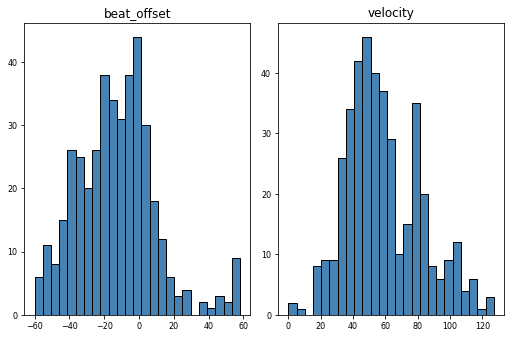

In [61]:
tmp_df_2.hist(column=['beat_offset', 'velocity'], bins=25, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

## Histograms - all instruments in a song, upbeats vs. downbeats

In [0]:
downs = list(range(1, 16, 2))
ups = list(range(2, 16, 2))
downbeats = tmp_df_2[tmp_df_2.index.isin(downs, level='bar_beat_number')]
upbeats = tmp_df_2[tmp_df_2.index.isin(ups, level='bar_beat_number')]

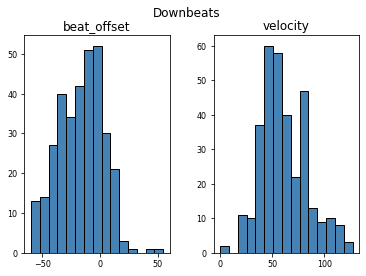

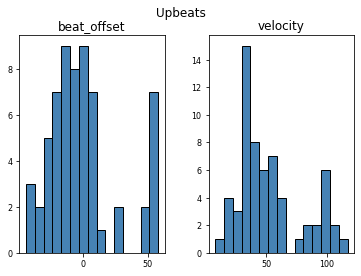

In [63]:
_ = downbeats.hist(column=['beat_offset', 'velocity'], bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
_ = plt.suptitle('Downbeats');
plt.show();

_ = upbeats.hist(column=['beat_offset', 'velocity'], bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
_ = plt.suptitle('Upbeats');
plt.show();

## Histograms - separate instruments in a song

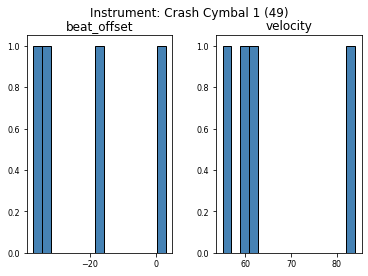

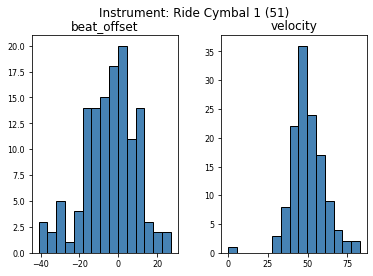

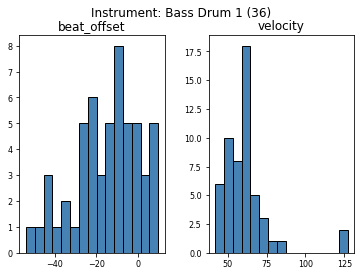

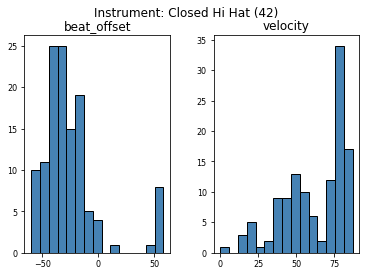

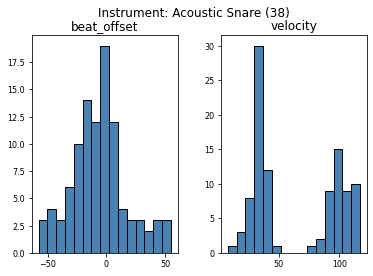

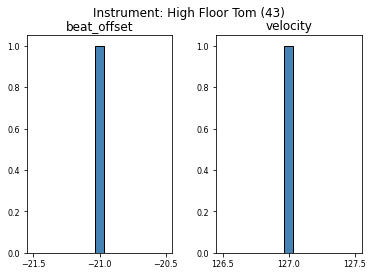

In [64]:
for i in tmp_df_2.note.unique():
  _ = tmp_df_2[tmp_df_2['note'] == i].hist(column=['beat_offset', 'velocity'], bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
          xlabelsize=8, ylabelsize=8, grid=False);
  _ = plt.suptitle('Instrument: {}'.format(data_prep.MidiTools.mapInstrument(i)));
  plt.show();
  

Boxplotting